In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
import evaluate

c:\Users\hardi\OneDrive\Desktop\personality_bot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
columns = ['question', 'answer']
df = pd.read_csv('dialogs.txt', sep='\t', names=columns)

In [3]:
df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [4]:
df.shape

(3725, 2)

## using lda for topic modelling

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['question'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
# Display the top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:", ", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]))

Topic 0: think, really, time, maybe, mean, ve, ll, better, let, doing
Topic 1: like, yes, want, didn, day, right, say, does, going, just
Topic 2: good, know, don, need, sure, course, great, job, new, haven
Topic 3: did, people, lot, school, don, today, really, yes, oh, think
Topic 4: ll, going, okay, nice, money, got, just, think, make, car


In [9]:
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

# Analyze language complexity
avg_question_word_length = df['question'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()
avg_answer_word_length = df['answer'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()

print("\nAverage word length in questions:", avg_question_word_length)
print("Average word length in answers:", avg_answer_word_length)


Average word length in questions: 4.166015845093442
Average word length in answers: 4.175336153968232


In [14]:
df['question_len']= df['question'].apply(lambda x: len(x))
df['answer_len']= df['answer'].apply(lambda x: len(x))

In [15]:
df.head()

,question,answer,question_word_count,answer_word_count,question_len,answer_len
0,"hi, how are you doing?",i'm fine. how about yourself?,5,5,22,29
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,5,6,29,35
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,6,7,35,33
3,no problem. so how have you been?,i've been great. what about you?,7,6,33,32
4,i've been great. what about you?,i've been good. i'm in school right now.,6,8,32,40


In [17]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hardi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    preprocessed_text = ' '.join(tokens)
    
    return text

preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

preprocessed_df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_word_count,answer_word_count,question_len,answer_len
0,"hi, how are you doing?",i'm fine. how about yourself?,5,5,22,29
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,5,6,29,35
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,6,7,35,33
3,no problem. so how have you been?,i've been great. what about you?,7,6,33,32
4,i've been great. what about you?,i've been good. i'm in school right now.,6,8,32,40
...,...,...,...,...,...,...
3720,that's a good question. maybe it's not old age.,are you right-handed?,9,3,47,21
3721,are you right-handed?,yes. all my life.,3,4,21,17
3722,yes. all my life.,you're wearing out your right hand. stop using...,4,11,17,58
3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.,11,10,58,43


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df['question'], preprocessed_df['answer'], test_size=0.2, random_state=42, shuffle=True)

In [20]:
Pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

Pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [21]:
Pipe.predict(['what are you doing'])[0]

"i'm going to change the light bulb. it burnt out."

In [22]:
predicted_text = Pipe.predict(X_test)

comparison_df = pd.DataFrame({'Real Question ': X_test[:10],'Real Generated Text': y_test[:10], 'Predicted Text': predicted_text[:10]})
comparison_df.head(10)

,Real Question,Real Generated Text,Predicted Text
554,i want to. i heard it's going to be really fun.,"i know, it does sound pretty awesome.",can you make it?
3373,who did you vote for?,i voted for obama.,"same as ever, by mail. all it costs me is a 42..."
3600,so has everyone else.,nothing seems to work.,but a cop might stop you.
2666,of course i'm sure.,"well, i have to go back upstairs anyway.",i don't have enough will power.
1406,did he ever take art lessons?,i can't believe it. i drew paintings like that...,forget it. golf sounds more like work than fun.
184,she's one of the prettiest girls at the school.,what does she look like?,maybe we should learn some good jokes.
2956,what makes him so bad?,he's rude and he yells a lot.,"for me, it's the students."
486,i always do. did you go to school today?,"no, i didn't.",so do i.
3592,i know that.,so why are you arguing with me? don't lie in t...,but you're doing 75.
2053,i wonder if i should bring my gloves.,"maybe you should, just in case it gets colder.",i did too.


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

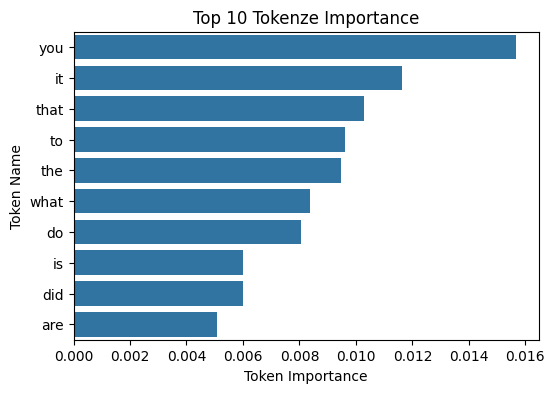

In [26]:
if isinstance(Pipe.named_steps['classifier'], RandomForestClassifier):
    feature_importances = Pipe.named_steps['classifier'].feature_importances_
    feature_names = Pipe.named_steps['tfidf'].get_feature_names_out()

    # Sort feature importances
    sorted_indices = feature_importances.argsort()[::-1]
    top_feature_importances = feature_importances[sorted_indices][:10]
    top_feature_names = np.array(feature_names)[sorted_indices][:10]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_feature_importances, y=top_feature_names)
    plt.xlabel('Token Importance')
    plt.ylabel('Token Name')
    plt.title('Top 10 Tokenze Importance')
    plt.show()

In [31]:
def get_response(question):
    response = Pipe.predict([question])[0]
    return response

def chat():
    while True:
        question = input("You: ")
        if question.lower() == 'quit':
            print("user:", question)
            print("Chatbot: Goodbye!")
            break
        response = get_response(question)
        print("user:", question)
        print("Chatbot:", response)

chat()

user: quit
Chatbot: Goodbye!


In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate

In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata


nltk.download('punkt')

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Function for preprocessing text
def preprocess_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + "<eos>"
    return text

preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

preprocessed_df.head()

<>:18: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\S'
C:\Users\hardi\AppData\Local\Temp\ipykernel_22008\232179867.py:18: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('\S*\d\S*\s*','', text)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_word_count,answer_word_count,question_len,answer_len
0,<sos> hi how are you doing <eos>,<sos> i m fine how about yourself <eos>,5,5,22,29
1,<sos> i m fine how about yourself <eos>,<sos> i m pretty good thanks for asking <eos>,5,6,29,35
2,<sos> i m pretty good thanks for asking <eos>,<sos> no problem so how have you been <eos>,6,7,35,33
3,<sos> no problem so how have you been <eos>,<sos> i ve been great what about you <eos>,7,6,33,32
4,<sos> i ve been great what about you <eos>,<sos> i ve been good i m in school right now ...,6,8,32,40


In [35]:
questions = preprocessed_df['question'].values.tolist()
answers = preprocessed_df['answer'].values.tolist()

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(np.concatenate((questions, answers), axis=0))

vocab_size = len(tokenizer.word_index) + 1

question_seqs = tokenizer.texts_to_sequences(questions)
answer_seqs = tokenizer.texts_to_sequences(answers)

max_len_question = max(len(seq) for seq in question_seqs)
max_len_answer = max(len(seq) for seq in answer_seqs)
max_len = max(max_len_question, max_len_answer)
print(max(max_len_question, max_len_answer))

question_seqs = pad_sequences(question_seqs, maxlen=max_len, padding='post')
answer_seqs = pad_sequences(answer_seqs, maxlen=max_len, padding='post')

22


In [36]:
tokenizer.texts_to_sequences("<sos>")

[[], [9], [490], [9], []]

In [37]:
tokenizer.word_index["<sos>"]

1

In [38]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate, Dropout

# Define the model architecture
latent_dim = 256  # Dimensionality of the encoding space

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len,))
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [state_h, state_c]



c:\Users\hardi\OneDrive\Desktop\personality_bot\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# Decoder
decoder_inputs = Input(shape=(max_len-1,))
decoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len-1,))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding(decoder_inputs), initial_state=encoder_states)



In [40]:
# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Add dropout layer for regularization
decoder_concat_input = Dropout(0.1)(decoder_concat_input)

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

In [41]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Print model summary
model.summary()

# Train the model
model.fit([question_seqs, answer_seqs[:, :-1]], answer_seqs[:, 1:],
          batch_size=64,
          epochs=32,
          validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 256)   │    616,960 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 21, 256)   │    616,960 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 22, 256), │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 21, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 21, 256)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21, 512)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 21, 512)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 21, 2410)  │  1,236,330 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,520,874 (13.43 MB)

 Trainable params: 3,520,874 (13.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


c:\Users\hardi\OneDrive\Desktop\personality_bot\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 361ms/step - loss: 4.2540 - val_loss: 2.3015
Epoch 2/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - loss: 2.0173 - val_loss: 2.2491
Epoch 3/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - loss: 1.9505 - val_loss: 2.2398
Epoch 4/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - loss: 1.8951 - val_loss: 2.1951
Epoch 5/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - loss: 1.8299 - val_loss: 2.1550
Epoch 6/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - loss: 1.7544 - val_loss: 2.1237
Epoch 7/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 352ms/step - loss: 1.7238 - val_loss: 2.1074
Epoch 8/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - loss: 1.6632 - val_loss: 2.0894
Epoch 9/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - loss: 1.6052 - val_loss: 2.0731
Epoch 10/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - loss: 1.5482 - val_loss: 2.0672
Epoch 11/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 339ms/step - loss: 1.5235 - val_loss: 2.0771
Epoch 12/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/ste

In [ ]:
def generate_response(input_text):
    # Tokenize the input text
    input_sequence = tokenizer.texts_to_sequences([input_text])
    # Pad the input sequence
    input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding='post')
    
    # Initialize the decoder input sequence with start token
    decoder_input_sequence = np.zeros((1, max_len-1))
    decoder_input_sequence[0, 0] = tokenizer.word_index['<sos>']
    
    # Generate response using the trained model
    for i in range(max_len - 1):
        predictions = model.predict([input_sequence, decoder_input_sequence])
        predicted_id = np.argmax(predictions[0, i, :])
        if predicted_id == tokenizer.word_index['<eos>']:
            break
        decoder_input_sequence[0, i+1] = predicted_id
    
    # Convert output sequence to text
    output_text = ''
    for token_index in decoder_input_sequence[0]:
        if token_index == tokenizer.word_index['<eos>'] or token_index == 0:
            break
        output_text += tokenizer.index_word[token_index] + ' '
    
    return output_text.strip()

input_text = "where are you going"
response = generate_response(input_text)
print("Response:", response[5:])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Response:  i don t know i had to go to the airport
